In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ase import io
import re
from mpl_toolkits import mplot3d
from collections import defaultdict
%matplotlib inline
%matplotlib notebook


In [2]:
import pickle

logs = pickle.load(open("/home/michael/PycharmProjects/gaussian_job_manage/complete_logs.p", "rb"))

bad_catalysts = ["Ni_32a_32", "Ni_3a1_10", "Co_3a1_9_", "Fe_31a_11", "Ni_oct_desorbed_4_", "Co_31a_9_" 
                "Cr_32a_33", "Cr_32a_35", "Co_3a1_11", "Ni_31a_9_", "Co_3a1_7_", "Cr_31a_16", "Fe_3a1_11",
                "Cr_3a1_27", "Fe_31a_9_", "Mn_31a_12", "Ni_31a_11", "Ni_31a_10", "Mn_3a1_18", "Cr_3a1_16", 
                 "Mn_3a1_15", "Cr_31a_17", "Cr_32a_33", "Cr_3a1_3_", "Cr_31a_8_", "Cr_3a1_9_", "Cr_3a1_8_"]

logs = [x for x in logs if "/OOH/" in x and x.split("/")[4] not in bad_catalysts]
oh_logs = [x for x in logs if "/OH/" in x and x.split("/")[4] not in bad_catalysts]


In [3]:
def get_spin_dens(log):
    structure = io.read(log, format='gaussian-out')
    with open(log, "r") as f:
        lines = f.readlines()
    for line in lines[:2000]:
        if "NAtoms" in line:
            #print(line)
            num_atoms = int(re.findall(r"[-+]?\d*\.\d+|\d+", line)[0])
    for idx, line in enumerate(lines):
        if "Mulliken charges and spin densities" in line:
            #print(line)
            rel_index = idx+2 
            break

    spin_dens = []
    charges = []
    for line in lines[idx+2:idx+2+num_atoms]:
        spin_dens.append(float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[-1]))
        charges.append(float(re.findall(r"[-+]?\d*\.\d+|\d+", line)[-2]))

    return structure, spin_dens, charges

def get_h_bond_dist(log):
    structure = io.read(log, format='gaussian-out')
    positions = structure.get_positions()
    origin = positions[0]
    distances = []
    for xyz in positions:
        distances.append(np.sqrt((xyz[0]-origin[0])**2+(xyz[1]-origin[1])**2+(xyz[2]-origin[2])**2))
    
    nearest_neighbours = np.argpartition(distances, 6)
    nn = [x for x in nearest_neighbours[:6+1] if x != 0]
    atomic_nums = structure.get_atomic_numbers()
    
    for nn_index in nn:
        if atomic_nums[nn_index]==8:
            o_origin = positions[nn_index]
            o_distances = []
            for xyz in positions:
                o_distances.append(np.sqrt((xyz[0]-o_origin[0])**2+(xyz[1]-o_origin[1])**2+(xyz[2]-o_origin[2])**2))
            o_nearest_neighbours = np.argpartition(o_distances, 2)
            nn_o = [x for x in o_nearest_neighbours[:2+1] if x != nn_index]
            for second_nn_index in nn_o:
                if atomic_nums[second_nn_index]==8:
                    first_o_idx = nn_index
                    second_o_idx = second_nn_index
                    #print(second_o_idx)
    
    origin = positions[second_o_idx+1]
    distances = []
    for xyz in positions:
        distances.append(np.sqrt((xyz[0]-origin[0])**2+(xyz[1]-origin[1])**2+(xyz[2]-origin[2])**2))
    nearest_to_h_index = np.argpartition(distances, 3)
    nearest_to_h_index = [x for x in nearest_neighbours[:3+1] if x != second_o_idx+1]
    for idx in nearest_to_h_index:
        if atomic_nums[idx] in [7, 8] and idx != second_o_idx:
            return distances[idx]

In [4]:
cat_to_ooh_oo_colinearity = defaultdict(float)
cat_to_ooh_oo_chg = defaultdict(float)

cat_to_ooh_metal_spin_ratio = defaultdict(float)
metal_spin_d = defaultdict(float)
is_ferro = defaultdict(bool)
o_o_ratio = defaultdict(float)
for l in logs:
    structure, spin_d, charges = get_spin_dens(l)
    distances = []
    positions = structure.get_positions()
    atomic_nums = structure.get_atomic_numbers()

    origin = positions[np.argmax(atomic_nums)]
    for xyz in positions:
        distances.append(np.sqrt((xyz[0]-origin[0])**2+(xyz[1]-origin[1])**2+(xyz[2]-origin[2])**2))
    
    nearest_neighbours = np.argpartition(distances, 6)
    nn = [x for x in nearest_neighbours[:6+1] if x != np.argmax(atomic_nums)]
    
    stop = False
    for nn_index in nn:
        if atomic_nums[nn_index]==8 and not stop:
            o_origin = positions[nn_index]
            o_distances = []
            for xyz in positions:
                o_distances.append(np.sqrt((xyz[0]-o_origin[0])**2+(xyz[1]-o_origin[1])**2+(xyz[2]-o_origin[2])**2))
            o_nearest_neighbours = np.argpartition(o_distances, 3)
            nn_o = [x for x in o_nearest_neighbours[:3+1] if x != nn_index]
            for second_nn_index in nn_o:
                if atomic_nums[second_nn_index]==8:
                    first_o_idx = nn_index
                    second_o_idx = second_nn_index
                    second_o_orig = positions[second_o_idx]
                    second_o_dists = []
                    for xyz in positions:
                        second_o_dists.append(np.sqrt((xyz[0]-second_o_orig[0])**2+(xyz[1]-second_o_orig[1])**2+(xyz[2]-second_o_orig[2])**2))
                    second_o_nearest_neighbours = np.argpartition(second_o_dists, 3)
                    second_nn_o = [x for x in second_o_nearest_neighbours[:3+1] if x != nn_index]
                    for closest_to_nn_o in second_nn_o:
                        if atomic_nums[closest_to_nn_o]==1:
                            stop = True

    if "Co_hexa_4" in l or "Ni_oct_desorbed_4_" in l or "Ni_3a1_1" in l:
        continue
    print(l)
    print(spin_d[first_o_idx]*spin_d[second_o_idx])
    if spin_d[first_o_idx]>0 and spin_d[second_o_idx]>0 and spin_d[0]<0:
        is_ferro[l.split("/")[4]] = False
    elif spin_d[first_o_idx]<0 and spin_d[second_o_idx]<0 and spin_d[0]>0:
        is_ferro[l.split("/")[4]] = False
    else:
        is_ferro[l.split("/")[4]] = True
    
    cat_to_ooh_oo_colinearity[l.split("/")[4]] = spin_d[first_o_idx]*spin_d[second_o_idx]
    cat_to_ooh_oo_chg[l.split("/")[4]] = charges[first_o_idx]*charges[second_o_idx]

    metal_spin_d[l.split("/")[4]] = spin_d[np.argmax(atomic_nums)]
    if abs(spin_d[first_o_idx])>0.05 and abs(spin_d[second_o_idx])>0.05:
        o_o_ratio[l.split("/")[4]] = spin_d[first_o_idx]/spin_d[second_o_idx]
    #cat_to_ooh_oo_colinearity[l.split("/")[4]] = colinearity_oxygens/spin_d[0]

cat_to_oh_spin = defaultdict(float)
metal_spin_d_oh = defaultdict(float)
for l in oh_logs:
#for l in ['/home/michael/ht_scaling_results/Mn_hexa_1/OOH/tpssh-Mn-25-OOH-HS-freq.log']:
    structure, spin_d, charges = get_spin_dens(l)
    distances = []
    positions = structure.get_positions()
    atomic_nums = structure.get_atomic_numbers()

    origin = positions[np.argmax(atomic_nums)]
    for xyz in positions:
        distances.append(np.sqrt((xyz[0]-origin[0])**2+(xyz[1]-origin[1])**2+(xyz[2]-origin[2])**2))
    
    nearest_neighbours = np.argpartition(distances, 6)
    nn = [x for x in nearest_neighbours[:6+1] if x != np.argmax(atomic_nums)]
    
    for nn_index in nn:
        if atomic_nums[nn_index]==8:
            o_origin = positions[nn_index]
            o_distances = []
            for xyz in positions:
                o_distances.append(np.sqrt((xyz[0]-o_origin[0])**2+(xyz[1]-o_origin[1])**2+(xyz[2]-o_origin[2])**2))
            o_nearest_neighbours = np.argpartition(o_distances, 3)
            nn_o = [x for x in o_nearest_neighbours[:3+1] if x != nn_index]
            for second_nn_index in nn_o:
                if atomic_nums[second_nn_index]==1:
                    first_o_idx = nn_index
                    second_o_idx = second_nn_index

    if "Co_hexa_4" in l or "Ni_oct_desorbed_4_" in l or "Ni_3a1_1" in l:
        continue
    
    cat_to_oh_spin[l.split("/")[4]] = spin_d[first_o_idx]
    metal_spin_d_oh[l.split("/")[4]] = spin_d[np.argmax(atomic_nums)]


/home/michael/ht_scaling_results/Fe_31a_17/OOH/HS/Fe_31a_17_OOH_HS.log
0.04313273964
/home/michael/ht_scaling_results/Co_31a_23/OOH/LS/Co_31a_23_OOH_LS.log
0.0
/home/michael/ht_scaling_results/Mn_32a_35/OOH/HS/Mn_32a_35_OOH_HS.log
0.021888658076
/home/michael/ht_scaling_results/Ru_32a_34/OOH/LS/Ru_32a_34_OOH_LSb.log
0.018064152099000003
/home/michael/ht_scaling_results/Mn_31a_23/OOH/HS/Mn_31a_23_OOH_HS.log
0.01365433797
/home/michael/ht_scaling_results/Fe_3a1_5_/OOH/LS/Fe_3a1_5_OOH_LS.log
0.045438844032
/home/michael/ht_scaling_results/Ni_3a1_5_/OOH/LS/Ni_3a1_5_OOH_LS.log
0.166629645075
/home/michael/ht_scaling_results/Cr_3a1_28/OOH/HS/Cr_3a1_28_OOH_HS.log
0.003295309536
/home/michael/ht_scaling_results/Ru_3a1_1_/OOH/LS/Ru_3a1_1_OOH_LS.log
0.039063512429999996
/home/michael/ht_scaling_results/Fe_3a1_22/OOH/HS/Fe_3a1_22_OOH_HS.log
0.069697116561
/home/michael/ht_scaling_results/Co_penta_4/OOH/Co_penta_4_OOH_LS.log
0.0
/home/michael/ht_scaling_results/Ni_3a1_24/OOH/LS/Ni_3a1_24_OOH_LS.lo

/home/michael/ht_scaling_results/Cr_oct_desorbed_1_/OOH/HS/Cr_oct_desorbed_1_OOH_HS.log
0.006794150061
/home/michael/ht_scaling_results/Co_31a_5_/OOH/LS/Co_31a_5_OOH_LS.log
0.0
/home/michael/ht_scaling_results/Ni_3a1_3_/OOH/LS/forw/Ni_3a1_3_OOH_LS-f_3e-1.log
0.21051654541700002
/home/michael/ht_scaling_results/Co_32a_32/OOH/LS/Co_32a_32_OOH_LSb.log
0.0
/home/michael/ht_scaling_results/Ru_31a_2_/OOH/LS/Ru_31a_2_OOH_LS.log
0.057831496940000005
/home/michael/ht_scaling_results/Ni_oct_desorbed_2_/OOH/LS/Ni_oct_desorbed_2_OOH_LS.log
0.0763910381
/home/michael/ht_scaling_results/Ru_3a1_20/OOH/LS/Ru_3a1_20_OOH_LS.log
0.017285343649
/home/michael/ht_scaling_results/Co_3a1_25/OOH/LS/Co_3a1_25_OOH_LS.log
0.0
/home/michael/ht_scaling_results/Ru_oct_desorbed_6_/OOH/LS/Ru_oct_desorbed_6_OOH_LS.log
0.018834204293999998
/home/michael/ht_scaling_results/Mn_31a_15/OOH/HS/Mn_31a_15_OOH_HS.log
0.010741271310000002
/home/michael/ht_scaling_results/Ni_41a_1_/OOH/LS/Ni_41a_1_OOH_LS-cartesian.log
0.208135032

/home/michael/ht_scaling_results/Ni_31a_13/OOH/LS/Ni_31a_13_OOH_LS.log
0.18748476626299998
/home/michael/ht_scaling_results/Ru_31a_4_/OOH/LS/Ru_31a_4_OOH_LS.log
0.049323738224
/home/michael/ht_scaling_results/Ru_3a1_4_/OOH/LS/Ru_3a1_4_OOH_LS.log
0.040762095761
/home/michael/ht_scaling_results/Co_3a1_13/OOH/LS/Co_3a1_13_OOH_LS.log
0.0
/home/michael/ht_scaling_results/Co_31a_26/OOH/LS/Co_31a_26_OOH_LS.log
0.0
/home/michael/ht_scaling_results/Ru_31a_5_/OOH/LS/Ru_31a_5_OOH_LS.log
0.048464865688
/home/michael/ht_scaling_results/Ru_31a_28/OOH/LS/Ru_31a_28_OOH_LS.log
0.029097679918
/home/michael/ht_scaling_results/Mn_oct_desorbed_3_/OOH/HS/Mn_oct_desorbed_3_OOH_HS.log
0.015178541154
/home/michael/ht_scaling_results/Co_penta_2/OOH/Co_penta_2_OOH_LS.log
0.0
/home/michael/ht_scaling_results/Cr_3a1_4_/OOH/HS/Cr_3a1_4_OOH_HS.log
0.004323097532
/home/michael/ht_scaling_results/Co_31a_18/OOH/LS/Co_31a_18_OOH_LS.log
0.0
/home/michael/ht_scaling_results/Co_3a1_26/OOH/LS/Co_3a1_26_OOH_LS.log
0.0
/home/

In [5]:
valid_convergers = pickle.load(open("well_behaved_cats.p", "rb"))

valid_names = list(set([x.split("/")[4] for x in valid_convergers]))
print(len(valid_names))
data = pickle.load(open("/home/michael/PycharmProjects/gaussian_job_manage/catalyst_data.p", 'rb'))

catnames = []
oh_values = []
ooh_values = []

for name in data:
    if "pbp" in name or name not in valid_names and "hexa" not in name:
        continue
    catnames.append(name)
    oh_values.append(data[name][0])
    ooh_values.append(data[name][1])
    
def deviation_from_scaling(oh_val, ooh_val):
    return ooh_val - 0.9*oh_val - 3.4

name2deviation = defaultdict(float)
for oh, ooh, name in zip(oh_values, ooh_values, catnames):
    name2deviation[name] = deviation_from_scaling(oh, ooh)

218


In [6]:
print(catnames[np.argmax(ooh_values)])

Ni_31a_19


In [7]:
colinearity = []
deviation = []
metal_s = []
ferro_or_not = []
charges = []
oh_spin = []
# TO DO: Compare differences vs. OH intermediate?
for val in name2deviation:
    if val in cat_to_ooh_oo_colinearity:
        colinearity.append(cat_to_ooh_oo_colinearity[val])
        deviation.append(name2deviation[val])
        metal_s.append(metal_spin_d[val])
        ferro_or_not.append(int(is_ferro[val]))
        charges.append(cat_to_ooh_oo_chg[val])
        oh_spin.append(cat_to_oh_spin[val])
        if "Ni" in val and cat_to_ooh_oo_colinearity[val]<0.1:
        #if cat_to_ooh_oo_colinearity[val]>0.1:
            print(val)
            print(name2deviation[val])
            print(metal_spin_d[val])
            print(cat_to_ooh_oo_colinearity[val])
        #if name2deviation[val]<-.4:
        #    print(val)
        #    print(cat_to_ooh_oo_colinearity[val])
        #    print(name2deviation[val])
         #   print(metal_spin_d[val])
#name2deviation

Ni_hexa_1
-0.03508856267357663
0.349843
0.09110831067000001
Ni_oct_desorbed_2_
0.07530895789779857
1.258565
0.0763910381


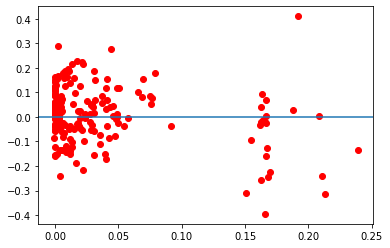

In [8]:
plt.plot(colinearity, deviation, 'ro')
plt.axhline(0)

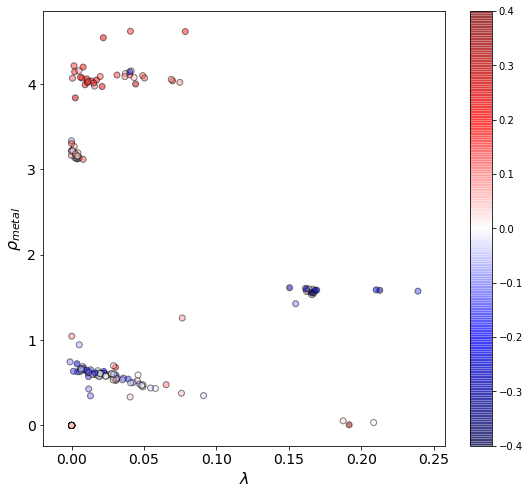

In [9]:

fig = plt.figure(figsize=(9,8))
#ax = plt.axes(projection='3d')
plt.scatter(colinearity, metal_s, c=deviation, cmap='seismic', alpha=0.5,edgecolors='k');
#ax.view_init(60, 15)

plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel(r"$\rho_{metal}$", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.zlabel("Deviation from scaling")
plt.colorbar()
#plt.savefig("3d_30.pdf")
plt.clim(-.4,.4) 


In [10]:
h_bond_distances = defaultdict()

for l in logs:
    #print(l)
    if "Ni_oct_desorbed_4_" in l or "Ni_3a1_1" in l or "hexa" in l:
        continue
    h_bond_distances[l.split("/")[4]] = get_h_bond_dist(l)



In [11]:
colinearity = []
deviation = []
metal_s = []
h_bond_dist = []
for val in name2deviation:
    if val in cat_to_ooh_oo_colinearity and val in h_bond_distances:
        colinearity.append(cat_to_ooh_oo_colinearity[val])
        deviation.append(name2deviation[val])
        h_bond_dist.append(h_bond_distances[val])
        metal_s.append(metal_spin_d[val])

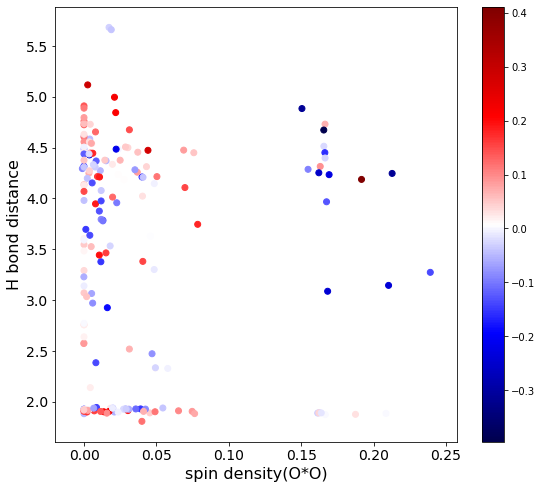

In [12]:

fig = plt.figure(figsize=(9,8))
#ax = plt.axes(projection='3d')
plt.scatter(colinearity, h_bond_dist, c=deviation, cmap='seismic');
#ax.view_init(60, 15)

plt.xlabel("spin density(O*O)", fontsize=16)
plt.ylabel("H bond distance", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.zlabel("Deviation from scaling")
plt.colorbar()